# Fitting a Cosmological Model to Observational Data

Michael Lindner \
University of Washington \
Autumn 2020

### Part a: Exploring the data

We'll begin by looking at the data.

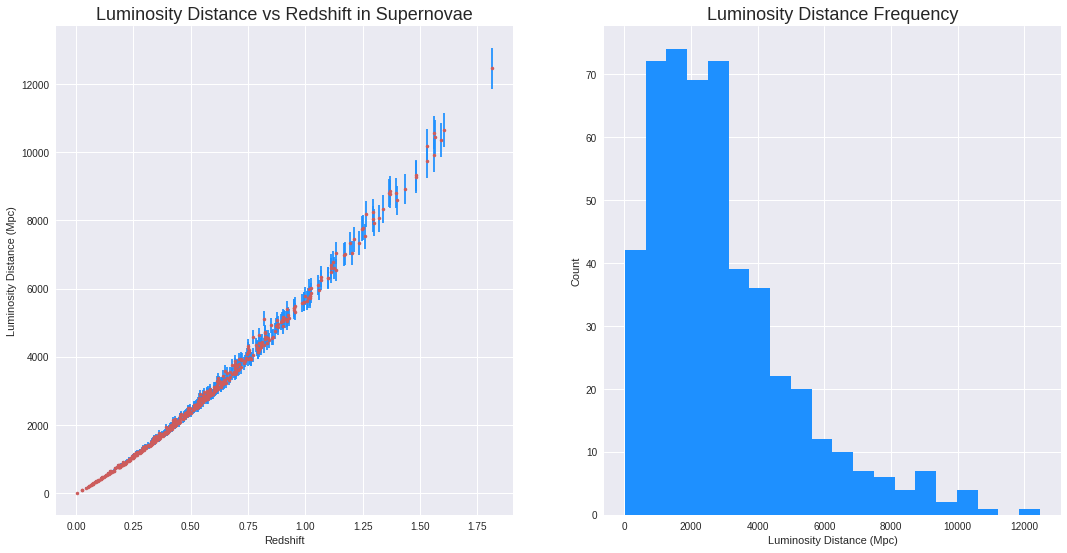

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn')

cols = ['Redshift', 'Distance', 'Error']
obs = pd.read_csv('SN.data', names=cols, header=0)

fig, ax = plt.subplots(1, 2, figsize=(18,9))
ax[0].errorbar(obs['Redshift'], obs['Distance'], yerr=obs['Error'], ls='None', marker='.', color='indianred', ecolor='dodgerblue')
ax[0].set_ylabel('Luminosity Distance (Mpc)')
ax[0].set_xlabel('Redshift')
ax[0].set_title('Luminosity Distance vs Redshift in Supernovae', fontsize=18);

ax[1].hist(obs['Distance'], bins = 20, color='dodgerblue');
ax[1].set_ylabel('Count')
ax[1].set_xlabel('Luminosity Distance (Mpc)')
ax[1].set_title('Luminosity Distance Frequency', fontsize=18);


We can see that error increases with redshift. We expect that our model will be more accurate and fit the data more closely at lower redshifts.

### Part b: Fitting a cosmological model with Markov chain Montey Carlo

We will be using Markov chain Monte Carlo because this is really an integration problem. MCMC methods create samples from continuous random variables, with probability densities proportional to known functions (priors). These samples can be used to evaluate integrals over those variables. We want to obtain the marginalized pdfs of each parameter by intergrating the three-dimensional posterior over the other variables. This is how we'll determine the best cosmological model to fit the given data.

For each cosmological parameter, we will be using a uniform distribution as a prior. There's no reason to assume any value would be more likely than any other. The ranges for these uniform distributions will be restricted to values that we could reasonable expect the parameter to take.

Our likelyhood will be astropy cosmology's luminosity_distance() function using a cosmology parameterized by H0, Om0, and Ode0. We will be assuming a normal distribution for the measured luminosity distance data with standard deviations given by the included errors.

In [2]:
from astropy.cosmology import LambdaCDM
import pymc3 as pm
import theano
import theano.tensor as t

# A utility function to convert the traces (chains) to a Pandas DataFrame
def traces_to_pandas(traces, burnin):
    varnames = [ var for var in traces.varnames if not var.endswith("_interval__") ]
    cols = { var: traces[var, :burnin] for var in varnames }
    return pd.DataFrame(cols)

data = obs['Distance']
data_err = obs['Error']
redshifts = obs['Redshift']

@theano.compile.ops.as_op(itypes=[t.dscalar, t.dscalar, t.dscalar],otypes=[t.dvector])
def cosmo_model(H0, Om0, Ode0):
    z = redshifts
    cosmo = LambdaCDM(H0=float(H0), Om0=float(Om0), Ode0=float(Ode0))
    def function(z):
        return cosmo.luminosity_distance(z).value
    
    function = function(z)
    return function

with pm.Model() as model:
    # Parameters should have uniform priors
    H0 = pm.Uniform('H0', lower=40, upper=100)
    Om0 = pm.Uniform('Om0', lower=0, upper=1)
    Ode0 = pm.Uniform('Ode0',lower=0,upper=1)
    
    likelyhood=cosmo_model(H0, Om0, Ode0)
    
    # Likelyhood of observed data
    dist = pm.Normal('LumDist', likelyhood, observed=data, sd=data_err)
    
    step = pm.Metropolis()
    traces = pm.sample(draws=25000, tune=1000, step=step, chains=4)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [Ode0]
>Metropolis: [Om0]
>Metropolis: [H0]


Sampling 4 chains for 1_000 tune and 25_000 draw iterations (4_000 + 100_000 draws total) took 136 seconds.
The number of effective samples is smaller than 10% for some parameters.


Taking a look at the traces to make sure things converged:

In [3]:
traces_to_pandas(traces, 1000)

,H0,Om0,Ode0
0,82.738441,0.224509,0.706098
1,82.738441,0.224509,0.706098
2,82.738441,0.224509,0.693651
3,82.738441,0.224509,0.695210
4,82.738441,0.224509,0.695210
...,...,...,...
99995,81.777772,0.243293,0.662954
99996,81.777772,0.243293,0.662954
99997,81.777772,0.243293,0.662954
99998,81.777772,0.243293,0.662954


Our fit converged on a value of 81.777 for $H_0$, 0.243 for $\Omega_{m,0}$, and 0.663 for $\Omega_{\Lambda,0}$. This seems reasonable when compared to common values assigned to these parameters. Now we can use the parameters from our fit to construct a cosmological model using Astropy.

In [70]:
MCMC_fit =  LambdaCDM(H0=traces['H0'][-1], Om0=traces['Om0'][-1], Ode0=traces['Ode0'][-1])

obs['Fit'] = MCMC_fit.luminosity_distance(obs['Redshift']).value
obs['Fit_Diff'] = np.abs(obs['Distance']-obs['Fit'])


Taking a look at the distances predicted by our model at the redshifts given in the data:

In [71]:
obs

,Redshift,Distance,Error,Fit,Fit_Diff
0,0.336886,1480.919735,73.014139,1522.757223,41.837487
1,0.186857,750.610735,37.321367,777.900408,27.289673
2,0.442316,2088.225990,100.775470,2101.209793,12.983803
3,0.388877,1789.298150,86.443520,1802.723517,13.425367
4,0.181246,768.578074,36.080277,751.996855,16.581219
...,...,...,...,...,...
495,0.140422,554.107761,27.264601,568.031351,13.923590
496,0.919220,5040.818899,249.077286,5163.955207,123.136308
497,0.429994,1984.276772,97.424628,2031.453558,47.176786
498,0.239588,1014.942769,49.325590,1028.466681,13.523912


### Part c: Estimating goodness of fit

We can use chi squared as an estimator of goodness of fit. Chi squared is usuful because it accounts for both accuracy and simplicity of the model. A lower chi squared means a better model. We could calculate this by hand, but scipy makes it easy:

In [8]:
from scipy.stats import chisquare

chisquare(obs.Distance, obs.Fit)


Power_divergenceResult(statistic=1191.754033949063, pvalue=1.4469899181080256e-58)

$$\chi^2 = 1191.754$$ \
We should also look at the error estimate of the uncertainties in the derived cosmological parameters:

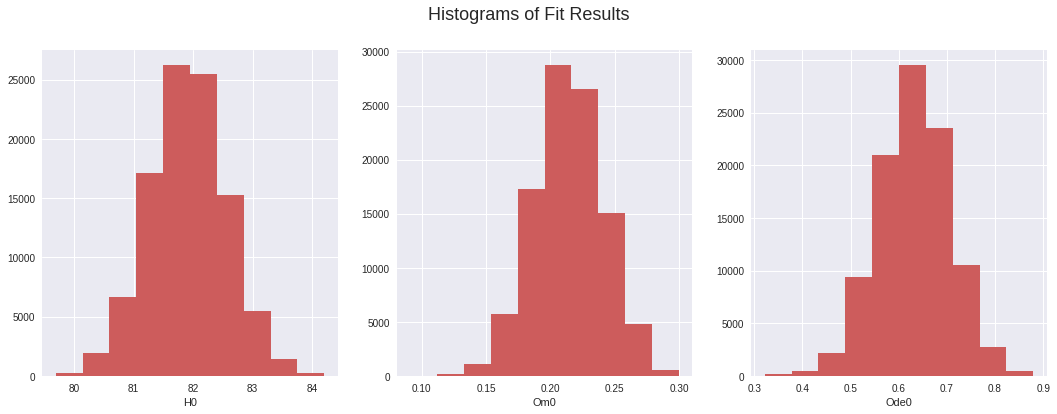

In [66]:
fig, ax = plt.subplots(1,3, figsize = (18,6))
ax[0].hist(traces['H0'], color='indianred')
ax[0].set_xlabel('H0')

ax[1].hist(traces['Om0'], color='indianred')
ax[1].set_xlabel('Om0')

ax[2].hist(traces['Ode0'], color='indianred')
ax[2].set_xlabel('Ode0')

fig.suptitle('Histograms of Fit Results', fontsize=18);

In [69]:
H0_sd = traces['H0'].std()
Om0_sd = traces['Om0'].std()
Ode0_sd = traces['Ode0'].std()

print(H0_sd, Om0_sd, Ode0_sd)

0.6450970054370588 0.026929246927270754 0.07463983257632725


Our estimate for H0 has a standard deviation of 0.645. Our estimate for Om0 has a standard deviation of 0.027. Our estimate for Ode0 has a standard deviation of 0.075.

$$ H_0 = 81.777 \pm 0.645 $$
$$ \Omega_{m,0} = 0.243 \pm 0.027 $$
$$ \Omega_{\Lambda,0} = 0.663 \pm 0.075 $$

### Part d: Visualization of our model

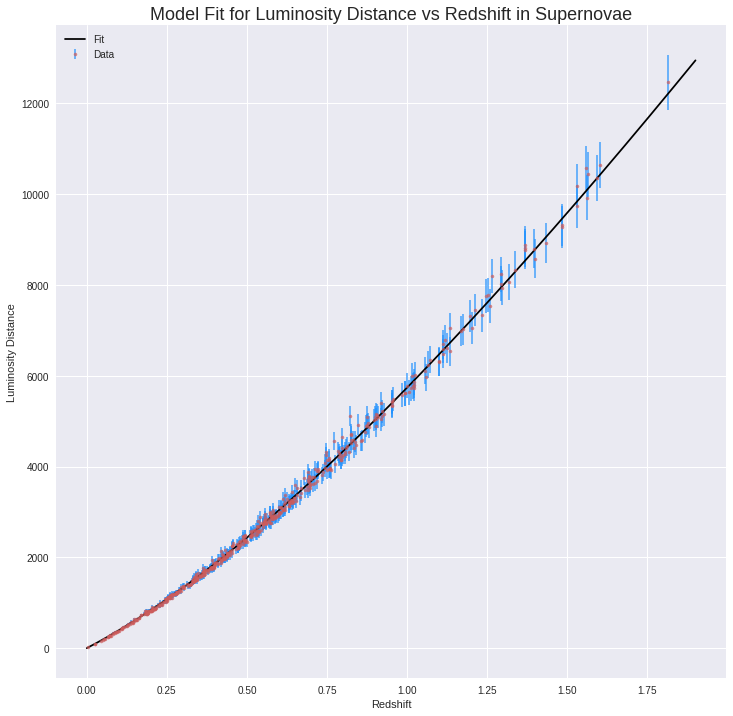

In [54]:
redshifts_smooth = np.linspace(0,1.9,500)

fig, ax = plt.subplots(figsize=(12,12))
ax.errorbar(obs['Redshift'], obs['Distance'], yerr=obs['Error'], ls='None', marker='.', alpha=.7, label='Data', color='indianred', ecolor='dodgerblue')
ax.plot(redshifts_smooth, MCMC_fit.luminosity_distance(redshifts_smooth).value, ls='-', c = 'k', label='Fit', alpha=1)
ax.set_ylabel('Luminosity Distance')
ax.set_xlabel('Redshift')
ax.set_title('Model Fit for Luminosity Distance vs Redshift in Supernovae', fontsize=18)
ax.legend(loc='upper left');


As expected, our model is more accurate at lower redshifts. The difference between our fit predictions and the observed data increase with redshift, as does the error in the observed data.

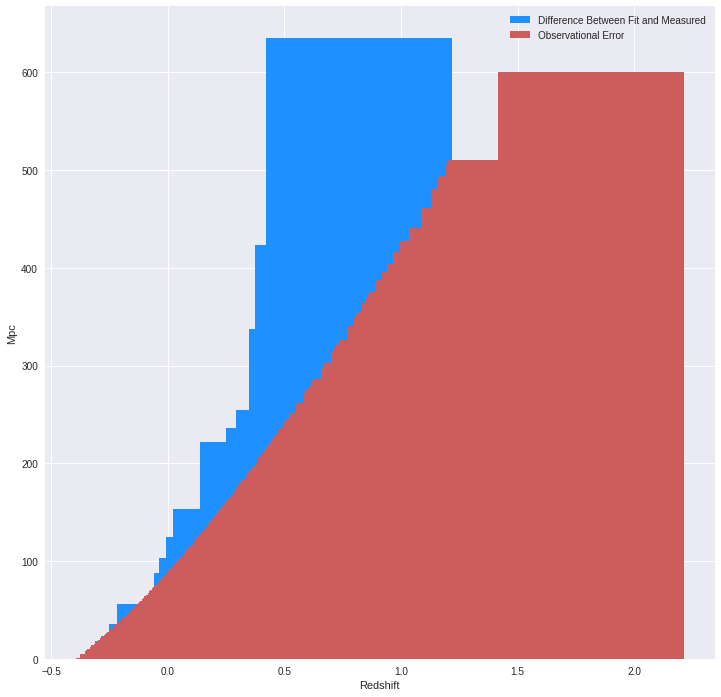

In [34]:
fig, ax = plt.subplots(figsize=(12,12))
ax.bar(obs['Redshift'], obs['Fit_Diff'], color='dodgerblue', label='Difference Between Fit and Measured')
ax.bar(obs['Redshift'], obs['Error'], color='indianred', label='Observational Error')
ax.set_xlabel('Redshift')
ax.set_ylabel('Mpc')
ax.legend()


### Part e: Visualizing uncertainty

In order to visualize the uncertainty in each of the parameters in our fit, we'll create a "corner plot" of the covarience in their values. We'll also plot the marginalized probability of each parameter's value.

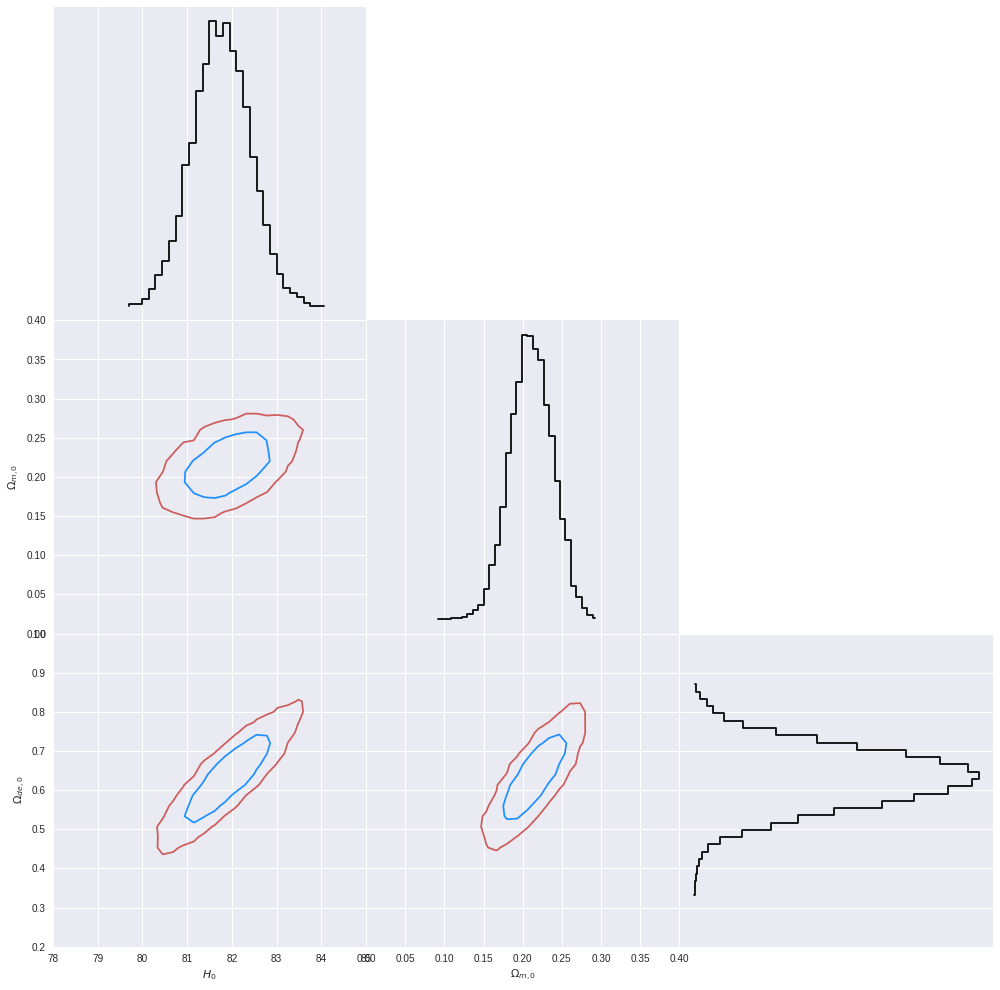

In [62]:
from astroML.plotting import hist, plot_mcmc

df = traces_to_pandas(traces, 1000)

variables = ['H0', 'Om0', 'Ode0']
labels = ['$H_0$', '$\Omega_{m,0}$', '$\Omega_{de,0}$']
limits = [(78, 85), (0, 0.4), (0.2, 1)]

fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc([df[col] for col in variables],
          labels=labels, limits=limits, fig=fig, bins=30, colors=['dodgerblue','indianred'])

# compute histogram of results to plot below
L_MCMC, H0_bins, Om0_bins1 = np.histogram2d(traces['H0'],
                                             traces['Om0'],
                                             bins=(30,30))

L_MCMC, Om0_bins2, Ode0_bins = np.histogram2d(traces['Om0'],
                                             traces['Ode0'],
                                             bins=(30,30))

Om0_bins = (Om0_bins1 + Om0_bins2) / 2

L_MCMC[L_MCMC == 0] = 1E-16  # prevents zero-division errors

hist_H0, bins_H0 = np.histogram(traces['H0'], bins=H0_bins, density=True)
hist_Om0, bins_Om0 = np.histogram(traces['Om0'],bins=Om0_bins, density=True)
hist_Ode0, bins_Ode0 = np.histogram(traces['Ode0'], bins=Ode0_bins, density=True)

# second axis: marginalized over H0
ax2 = fig.add_axes((0.08, .95, 0.435, 0.435))
ax2.yaxis.set_major_formatter(plt.NullFormatter())
ax2.plot(0.5 * (bins_H0[1:] + bins_H0[:-1]
                            - bins_H0[1] + bins_H0[0]),hist_H0, 
         '-k', drawstyle='steps')
ax2.set_xlim(limits[0])
ax2.xaxis.set_ticklabels([])
ax2.grid(b=None, axis='y')

# third axis: marginalized over Om0
ax3 = fig.add_axes((0.515, 0.515, 0.435, 0.435))
ax3.yaxis.set_major_formatter(plt.NullFormatter())
ax3.plot(0.5 * (bins_Om0[1:] + bins_Om0[:-1]
                                        - bins_Om0[1] + bins_Om0[0]), hist_Om0, 
         '-k', drawstyle='steps-mid')
ax3.set_xlim(limits[1])
ax3.xaxis.set_ticklabels([])
ax3.grid(b=None, axis='y')

# fourth axis: marginalized over Ode0
ax4 = fig.add_axes((.951, 0.08, 0.435, 0.435))
ax4.xaxis.set_major_formatter(plt.NullFormatter())
ax4.plot( hist_Ode0, 0.5 * (bins_Ode0[1:] + bins_Ode0[:-1]),
         '-k', drawstyle='steps-mid')
ax4.set_ylim(limits[2])
ax4.yaxis.set_ticklabels([])
ax4.grid(b=None, axis='x')

plt.show()


We can see that the spread in Ode0 is much larger than for the other parameters. A cosmological model could be more tightly constrained by H0 and Om0 than by Ode0. 

### Sources

https://github.com/uw-astr-324/astr-324-s20/blob/master/lectures/Week-06.2-MCMC-in-Python.ipynb \
https://docs.pymc.io/ \
https://docs.pymc.io/notebooks/blackbox_external_likelihood.html \
https://github.com/pymc-devs/pymc3/issues/601 \
https://www.astroml.org/book_figures/chapter5/fig_model_comparison_mcmc.html